# 階層的クラスタリング

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
import scipy.spatial.distance
from IPython.display import HTML

日本の行政区画は$47$の都道府県から構成され、その下に市町村や区が置かれている。また、$47$の都道府県も、北海道地方や東北地方など、いくつかのグループにまとめて語られることがある。これをクラスタ分析の用語で説明すると、市町村の上に都道府県のクラスタが作られ、都道府県の上に地方のクラスタ、地方のクラスタの上に「日本」というクラスタがあり、日本のクラスタの上に「アジア」のクラスタ……、といった具合で、クラスタに上下関係が存在している。

生物の[分類学](https://ja.wikipedia.org/wiki/%E5%88%86%E9%A1%9E%E5%AD%A6)、[日本十進分類法](https://ja.wikipedia.org/wiki/%E6%97%A5%E6%9C%AC%E5%8D%81%E9%80%B2%E5%88%86%E9%A1%9E%E6%B3%95)（図書館の本の分類）、会社の組織図、オブジェクト指向言語のクラスの階層など、階層構造は世の中の至るところで用いられる。モノを階層構造で表現することのメリットは、モノを見る細かさを階層のレベルで調整できることや、モノを探しやすくすることであろう。

**階層的クラスタリング**（hierarchical clustering）は、データからクラスタの階層構造を抽出する手法である。階層的クラスタリングは、凝集型と分割型に大別される。

+ **凝集型**（ボトムアップ型）： 各事例を要素数$1$のクラスタに格納し、クラスタを繰り返し併合していく方法
+ **分割型**（トップダウン型）： 全事例を一つの大きなクラスタに格納し、クラスタを繰り返し分割していく方法

ここでは、凝集型の階層的クラスタリングを取り上げる。

## 具体例

### データと距離行列

ここでは、凝集型クラスタリングの動作を具体例で示す。単純な例として、1次元（スカラー）の事例$5$件からなるデータ $X = (x_1, x_2, x_3, x_4, x_5) = (2, 11, 5, 1, 7)$ を考える。事例数を$N$で表すことにすると、$N=5$である。

２つの事例$x_i$と$x_j$の距離を$d_{i,j}$で表す。ここでは、$d_{i,j} = |x_i - x_j|$と定義する。例えば、$x_1$と$x_3$の距離は、

<a id="f11-1"></a>
(11.1)  
\begin{align}
d_{1,3} = |x_1 - x_3| = |2 - 5| = 3
\end{align}

さて、データ中の全ての事例の組に対して距離を計算し、$N \times N$の行列$\pmb{D} = (d_{i,j})$で表現する。データ$X$に対しては、

<a id="f11-2"></a>
(11.2)  
\begin{align}
\pmb{D} &= \begin{pmatrix}
|x_1 - x_1| & |x_1 - x_2| & |x_1 - x_3| & |x_1 - x_4| & |x_1 - x_5| \\
|x_2 - x_1| & |x_2 - x_2| & |x_2 - x_3| & |x_2 - x_4| & |x_2 - x_5| \\
|x_3 - x_1| & |x_3 - x_2| & |x_3 - x_3| & |x_3 - x_4| & |x_3 - x_5| \\
|x_4 - x_1| & |x_4 - x_2| & |x_4 - x_3| & |x_4 - x_4| & |x_4 - x_5| \\
|x_5 - x_1| & |x_5 - x_2| & |x_5 - x_3| & |x_5 - x_4| & |x_5 - x_5| \\
\end{pmatrix} \\
&= \begin{pmatrix}
|2 - 2| & |2 - 11| & |2 - 5| & |2 - 1| & |2 - 7| \\
|11 - 2| & |11 - 11| & |11 - 5| & |11 - 1| & |11 - 7| \\
|5 - 2| & |5 - 11| & |5 - 5| & |5 - 1| & |5 - 7| \\
|1 - 2| & |1 - 11| & |1 - 5| & |1 - 1| & |1 - 7| \\
|7 - 2| & |7 - 11| & |7 - 5| & |7 - 1| & |7 - 7| \\
\end{pmatrix} \\
&= \begin{pmatrix}
0 & 9 & 3 & 1 & 5 \\
9 & 0 & 6 & 10 & 4 \\
3 & 6 & 0 & 4 & 2 \\
1 & 10 & 4 & 0 & 6 \\
5 & 4 & 2 & 6 & 0 \\
\end{pmatrix}
\end{align}

なお、$\pmb{D}$は**距離行列**（distance matrix）と呼ばれる。$d_{i,j} = d_{j,i}$であることから、距離行列は$N \times N$の対称行列である。また、自分自身との距離は$0$であることから、距離行列の対角成分は$0$である。

### 実行例

In [2]:
import jinja2

def distance_matrix(X):
    return np.abs(X[:, None] - X).astype(float)

def merge_cluster_single(D, C, i, j):
    newD = np.copy(D)
    np.fill_diagonal(newD, np.nan)
    d = np.nanmin(np.array([newD[i], newD[j]]), axis=0)
    newD[i] = d
    newD[:,i] = d
    newD = np.delete(newD, j, 0)
    newD = np.delete(newD, j, 1)
    np.fill_diagonal(newD, 0)
    
    newC = list(C)
    newC[i] = set(sorted(newC[i] | newC[j]))
    del newC[j]
    return newD, tuple(newC)

def generate_distance_table(D, C):
    template = """
    <table>
    <tr>
      <th width="120px"></th>
      {% for item in C %}
      <th width="120px">{{ item }}</th>
      {% endfor %}
    </tr>
    {% for row in D %}
    <tr>
      <th>{{ C[loop.index0] }}</th>
      {% for v in row %}
      {% if v == minvalue %}
      <td style="text-decoration: underline; color: red;">{{ v }}</td>
      {% else %}
      <td>{{ v }}</td>
      {% endif %}
      {% endfor %}
    </tr>
    {% endfor %}
    </table>
    """
    tmpl = jinja2.Template(template)
    
    minvalue = np.min(scipy.spatial.distance.squareform(D)) if D.size > 1 else 0.
    return tmpl.render(D=D.astype(int), C=C, minvalue=minvalue)

さて、この距離行列を用いてクラスタを形成していく。凝集型のクラスタリングは、全ての事例が自身をのみを要素にもつクラスタを形成する状態を出発点とする。クラスタの要素を集合$\{\dots\}$でまとめることにすると、初期状態のクラスタを次のように表すことができる。

\begin{align*}
\left\{\{2\}, \{11\}, \{5\}, \{1\}, \{7\}\right\}
\end{align*}

この初期状態のクラスタの中で、距離の近いクラスタを併合するという操作を繰り返していく。この経過を分かりやすく説明するため、さきほどの距離行列を表として示す。クラスタの要素を保持する集合を行見出しと列見出しに、全てのクラスタ間の距離を表のセルに示した。

In [3]:
X = np.array([2, 11, 5, 1, 7])
C = tuple([{x,} for x in X])
D = distance_matrix(X)
HTML(generate_distance_table(D, C))

,{2},{11},{5},{1},{7}
{2},0,9,3,1,5
{11},9,0,6,10,4
{5},3,6,0,4,2
{1},1,10,4,0,6
{7},5,4,2,6,0


この表の非対角要素の中で、もっとも値が小さいものを下線および赤色で示した。これによると、$\{2\}$と$\{1\}$のクラスタ間の距離$1$が最小である。そこで、この２つのクラスタを併合し、$\{1,2\}$を要素にもつクラスタを作成したい。

ここで、新しく作成するクラスタ$\{1,2\}$とその他のクラスタ$\{11\}, \{5\}, \{7\}$との距離をどのように定義するか、検討しなければいけない。今回は、２つのクラスタ間の距離は、双方のクラスタに属する要素で総当りで距離を求め、その最小値と定義することにする（後で説明するが、これは最短距離法と呼ばれる）。すなわち、２つのクラスタを集合$A$と$B$で表現したとき、そのクラスタ間の距離$\mathrm{dist}(A, B)$を次式で定義する。

<a id="f11-3"></a>
(11.3)  
\begin{align}
\mathrm{dist}(A, B) = \min_{a \in A,\; b \in B} d(a, b)
\end{align}
ここで、$d(a,b)$は要素$a$と$b$の距離で、距離行列$D$の対応する要素を参照することで求める（$d_{ab}$と説明したいところであるが、$a$と$b$は行列におけるインデックス番号ではなく、データ中の要素そのものである）。

要素$i$と$j$を統合してクラスタ$\{i,j\}$を作成した時、それ以外の要素$h$ ($h \neq i$かつ$h \neq j$) との距離は次式で与えられる。

<a id="f11-4"></a>
(11.4)  
\begin{align}
\mathrm{dist}[\{i,j\}, \{h\}] = \min_{a \in \{i,j\},\; b=h} d(a, b) = \min \{ d(i,h), d(j,h) \}
\end{align}

ゆえに、

\begin{align*}
\mathrm{dist}[\{1,2\}, \{11\}] &= \min \{ d(1,11), d(2,11) \} = \min\{10, 9\} = 9 \\
\mathrm{dist}[\{1,2\}, \{5\}] &= \min \{ d(1,5), d(2,5) \} = \min\{4, 3\} = 3 \\
\mathrm{dist}[\{1,2\}, \{7\}] &= \min \{ d(1,7), d(2,7) \} = \min\{6, 5\} = 5
\end{align*}

今回の例では、クラスタの要素が整数であり、かつクラスタ間の距離は値の差の絶対値と定義したので、双方のクラスタに属する整数同士で距離（差の絶対値）を総当りで計算し、その最小値がクラスタ間の距離である。

新しく作成するクラスタ$\{1,2\}$と、それ以外のクラスタ$\{11\}, \{5\}, \{7\}$との距離を計算できたので、距離行列の表を更新する。

In [4]:
D2, C2 = merge_cluster_single(D, C, 0, 3)
HTML(generate_distance_table(D2, C2))

,"{1, 2}",{11},{5},{7}
"{1, 2}",0,9,3,5
{11},9,0,6,4
{5},3,6,0,2
{7},5,4,2,0


この表から、次に距離が近いのは$\{5\}$と$\{7\}$のクラスタで、その距離は$2$である。そこで、この２つのクラスタを併合し、$\{5,7\}$を要素にもつクラスタを作成する。先ほどと同様に、新しく作成するクラスタと、それ以外のクラスタとの距離を求める。ここで、クラスタ$A$と$B$を併合したクラスタを$A \cup B$で表すと、$A \cup B$とそれ以外のクラスタ$C$との距離は、

<a id="f11-5"></a>
(11.5)  
\begin{align}
\mathrm{dist}(A \cup B, C) = \min \{ \mathrm{dist}(A, C), \mathrm{dist}(B, C)\}
\end{align}

ゆえに、

\begin{align*}
\mathrm{dist}[\{5\}\cup\{7\}, \{1,2\}] &= \min \{ \mathrm{dist}[\{5\}, \{1,2\}], \mathrm{dist}[\{7\}, \{1,2\}] \} = \min\{3, 5\} = 3 \\
\mathrm{dist}[\{5\}\cup\{7\}, \{11\}] &= \min \{ d(5,11), d(7,11) \} = \min\{6, 4\} = 4 \\
\end{align*}

この結果に基づき、クラスタ$\{5,7\}$を作成し、距離行列の表を更新する。

In [5]:
D3, C3 = merge_cluster_single(D2, C2, 2, 3)
HTML(generate_distance_table(D3, C3))

,"{1, 2}",{11},"{5, 7}"
"{1, 2}",0,9,3
{11},9,0,4
"{5, 7}",3,4,0


この表から、次に距離が近いのは$\{1,2\}$と$\{5,7\}$のクラスタで、その距離は$3$である。この２つのクラスタを併合し、$\{1,2,5,7\}$を要素にもつクラスタを作成する。作成後のクラスタとその他のクラスタとの距離を求めると、

\begin{align*}
\mathrm{dist}[\{1,2\}\cup\{5,7\}, \{11\}] &= \min \{ \mathrm{dist}[\{1,2\}, \{11\}], \mathrm{dist}[\{5,7\}, \{11\}] \} = \min\{9, 4\} = 4 \\
\end{align*}

この計算結果に基づき、クラスタ$\{1,2,5,7\}$を作成し、距離行列の表を更新する。

In [6]:
D4, C4 = merge_cluster_single(D3, C3, 0, 2)
HTML(generate_distance_table(D4, C4))

,"{1, 2, 5, 7}",{11}
"{1, 2, 5, 7}",0,4
{11},4,0


最後に、クラスタ$\{1,2,5,7\}$と$\{11\}$を併合し、全ての事例が一つの大きなクラスタにまとめられる。

In [7]:
D5, C5 = merge_cluster_single(D4, C4, 0, 1)
HTML(generate_distance_table(D5, C5))

,"{1, 2, 5, 7, 11}"
"{1, 2, 5, 7, 11}",0


これまでの動作は以下のようにまとめられる。

1. $\{2\}$と$\{1\}$のクラスタ（距離=$1$）をまとめる
1. $\{5\}$と$\{7\}$のクラスタ（距離=$2$）をまとめる
1. $\{1,2\}$と$\{5,7\}$のクラスタ（距離=$3$）をまとめる
1. $\{1,2,5,7\}$と$\{11\}$のクラスタ（距離=$4$）をまとめる

### デンドログラム

このクラスタ形成のプロセスを**デンドログラム**（樹形図）として可視化すると分かりやすい。

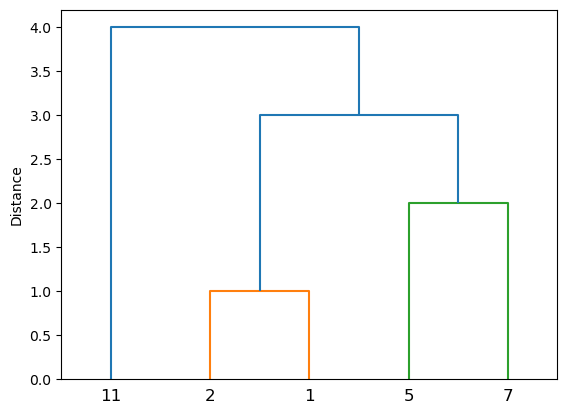

In [8]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'single')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

デンドログラムを見ると、クラスタ内の整数同士を総当りで比較して、その最小値の順にクラスタが形成されていることが一目瞭然であろう。

これまでの説明では、事例を個別のクラスタに割り当てた状態を出発点とし、最終的に全ての事例をまとめた一つのクラスタが形成された。ここで、クラスタ間の距離を閾値として設定すると、異なるクラスタ数の結果を得ることができる。例えば、

+ 距離の閾値を$1.5$とする（下図の点線）: $4$個のクラスタ$\{1,2\}, \{5\}, \{7\}, \{11\}$が得られる
+ 距離の閾値を$2.5$とする（下図の破線）: $3$個のクラスタ$\{1,2\}, \{5,7\}, \{11\}$が得られる
+ 距離の閾値を$1.5$とする（下図の一点鎖線）: $2$個のクラスタ$\{1,2,5,7\}, \{11\}$が得られる

凝集型クラスタリングを実際に用いるときは、距離の閾値を設定してクラスタ数を自動的に決めるか、指定したクラスタ数になるように自動的に閾値を調整することが多い。

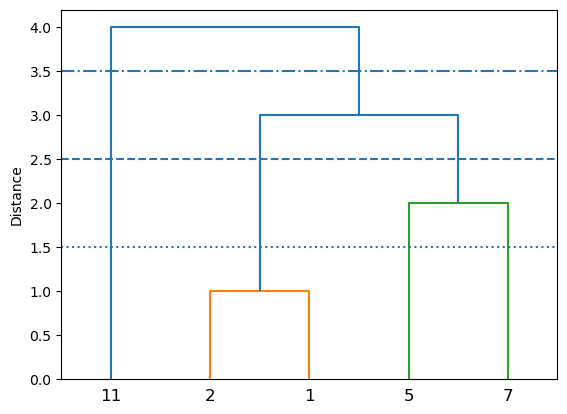

In [9]:
fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
left, right = ax.get_xlim()
plt.hlines([1.5], left, right, linestyles='dotted')
plt.hlines([2.5], left, right, linestyles='dashed')
plt.hlines([3.5], left, right, linestyles='dashdot')
ax.set_ylabel("Distance")
plt.show()

## 距離関数

先ほどの例では、数値の差の絶対値を要素間の距離として定義した。クラスタリングでは他にも様々な距離関数が用いられる。なお、$m$次元上のベクトルで定義された距離関数$d: \mathbb{R}^m \times \mathbb{R}^m \mapsto \mathbb{R}$は以下の性質を満たす。

+ $\forall \pmb{x}, \pmb{y} \in \mathbb{R}^m: d(\pmb{x}, \pmb{y}) \geq 0$
+ $\forall \pmb{x}, \pmb{y} \in \mathbb{R}^m: \pmb{x} = \pmb{y} \Rightarrow d(\pmb{x}, \pmb{y}) = 0$
+ $\forall \pmb{x}, \pmb{y} \in \mathbb{R}^m: d(\pmb{x}, \pmb{y}) = d(\pmb{y}, \pmb{x})$
+ $\forall \pmb{x}, \pmb{y}, \pmb{z} \in \mathbb{R}^m: d(\pmb{x}, \pmb{y}) + d(\pmb{y}, \pmb{z}) \geq d(\pmb{x}, \pmb{z})$　（三角不等式）

### ユークリッド距離

ユークリッド距離（$L_2$距離）は、ベクトル間の距離関数として最も基本的なものである。２つのベクトル$\pmb{x}, \pmb{y} \in \mathbb{R}^m$に対して、次式で定義される。

<a id="f11-6"></a>
(11.6)  
\begin{align}
d(\pmb{x}, \pmb{y}) = \|\pmb{x} - \pmb{y}\|_2 = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \dots + (x_m - y_m)^2}
\end{align}


### マンハッタン距離

マンハッタン距離（$L_1$距離）は、２つのベクトル$\pmb{x}, \pmb{y} \in \mathbb{R}^m$に対して、次式で定義される。

<a id="f11-7"></a>
(11.7)  
\begin{align}
d(\pmb{x}, \pmb{y}) = \|\pmb{x} - \pmb{y}\|_1 = |x_1 - y_1| + |x_2 - y_2| + \dots + |x_d - y_d|
\end{align}

なお、冒頭の例で用いた距離関数は$m=1$次元のときのマンハッタン距離である。

### コサイン類似度

２つのベクトル$\pmb{x}, \pmb{y} \in \mathbb{R}^m$があり、そのなす各を$\theta$とする。このとき、$\cos \theta$を$\pmb{x}$と$\pmb{y}$のコサイン類似度と呼ぶ。ベクトルの内積の公式より、

<a id="f11-8"></a>
(11.8)  
\begin{align}
\cos \theta = \frac{\pmb{x} \cdot \pmb{y}}{\|\pmb{x}\| \|\pmb{y}\|}
\end{align}

コサイン類似度は２つのベクトルの「似ている度合い」を$-1$（似ていない）から$1$（似ている）までの数値で表す。クラスタリングで距離として用いるときは、「似ていない度合い」、すなわち非類似度にするために$1$から引くことが多い（他の変換方法もあり得る）。

<a id="f11-9"></a>
(11.9)  
\begin{align}
d(\pmb{x}, \pmb{y}) = 1 - \frac{\pmb{x} \cdot \pmb{y}}{\|\pmb{x}\| \|\pmb{y}\|} = 1 - \cos \theta
\end{align}

なお、コサイン（非）類似度は三角不等式を満たさないため、厳密には距離関数と呼べないが、クラスタリングで用いられることがある。

In [10]:
from sklearn import datasets
P, q, centers = datasets.make_blobs(n_samples=15, centers=2, random_state=27, return_centers=True)
C0 = P[q == 0]
C1 = P[q == 1]
D = np.sqrt(((C0[:, None] - C1) ** 2).sum(2))
cmap = plt.get_cmap("tab10")

## 凝集型クラスタリング

クラスタ分析の対象となるデータ$X = (\pmb{x}_1, \pmb{x}_2, \dots, \pmb{x}_N)$が与えられる。凝集型クラスタリングでは、各事例がそれぞれ１つのクラスタを構成する状態を出発点とする。そして、クラスタ間距離関数（後述）で測定した距離が最も短い２つのクラスタを併合する、という操作を$N-1$回繰り返し、最終的に一つのクラスタにまとめ上げる。凝集型クラスタリング手法によって、異なるクラスタ間距離関数が用いられる。

### 最短距離法

冒頭の例で紹介したクラスタリング手法は**最短距離法**（nearest neighbour clustering）または**単連結法**（single-linkage clustering）と呼ばれる。$m$次元の事例ベクトル$\pmb{x}, \pmb{y} \in \mathbb{R}^m$の任意の距離関数を$d(\pmb{x}, \pmb{y})$とする。２つのクラスタ$C_a$と$C_b$があるとき、そのクラスタ間距離関数は、

<a id="f11-10"></a>
(11.10)  
\begin{align}
\mathrm{dist}_{\textrm{single}}(C_a, C_b) = \min_{\pmb{x} \in C_a,\; \pmb{y} \in C_b} d(\pmb{x}, \pmb{y})
\end{align}

これは、クラスタ$C_a$と$C_b$に所属する事例同士の距離を総当りで求めた時、その最小値である。以下の図は、丸印と四角印のクラスタ間の最短距離を求める例である。

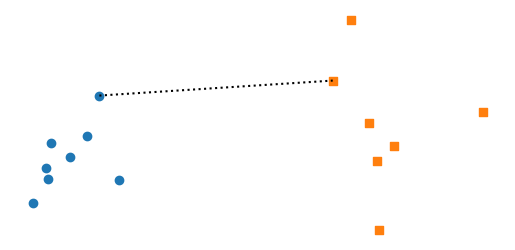

In [11]:
i, j = np.unravel_index(np.argmin(D), D.shape)

fig, ax = plt.subplots(dpi=100)
ax.scatter(C0[:,0], C0[:,1], color=cmap(0), marker='o')
ax.scatter(C1[:,0], C1[:,1], color=cmap(1), marker='s')
ax.plot([C0[i][0], C1[j][0]], [C0[i][1], C1[j][1]], linestyle=':', color='black')
ax.set_aspect('equal')
ax.axis("off")
plt.show()

$X = (2, 11, 5, 1, 7)$に対して最短距離法でクラスタリングを実行し、そのデンドログラムを描画した。なお、距離関数としてはユークリッド距離（１次元のデータに対してはマンハッタン距離と等しい）を用いた。

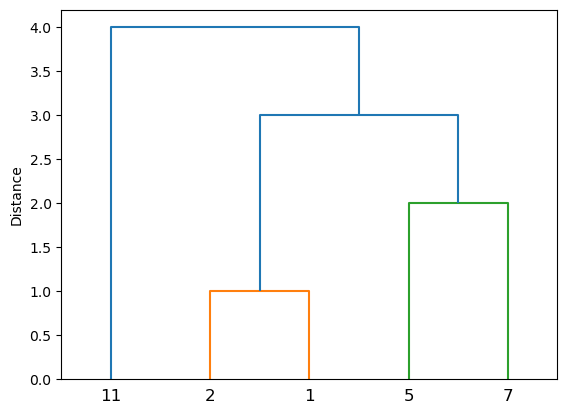

In [12]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'single')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

なお、最短距離法はクラスタが最も近い点を経由して連結されていくため、鎖状に連結されやすい。この現象は**連鎖**（chaining）と呼ばれる。その結果、距離がかなり離れている要素同士でもひとつのクラスタにまとめられてしまうことがある。クラスタ内の要素間の距離の最大値をクラスタの**直径**と呼ぶことにすると、最短距離法は直径の大きいクラスタを生成してしまうことがある。例えば、上のデンドログラムの例ではクラスタ$\{1,2\}$と$\{5,7\}$が併合されるときの距離は$3$であったが、距離が最も遠い要素の組の距離は$6$であるから、直径の大きいクラスタが生成されていることが分かる。

### 最長距離法

最短距離法と対極にあるのが、**最長距離法**（furthest neighbour clustering）または**完全連結法**（complete-linkage clustering）である。２つのクラスタ$C_a$と$C_b$があるとき、そのクラスタ間距離関数は、

<a id="f11-11"></a>
(11.11)  
\begin{align}
\mathrm{dist}_{\textrm{complete}}(C_a, C_b) = \max_{\pmb{x} \in C_a,\; \pmb{y} \in C_b} d(\pmb{x}, \pmb{y})
\end{align}

これは、クラスタ$C_a$と$C_b$に所属する事例同士の距離を総当りで求めた時、その最大値である。以下の図は、丸印と四角印のクラスタ間の最遠距離を求める例である。

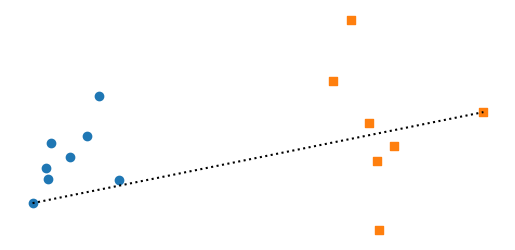

In [13]:
i, j = np.unravel_index(np.argmax(D), D.shape)

fig, ax = plt.subplots(dpi=100)
ax.scatter(C0[:,0], C0[:,1], color=cmap(0), marker='o')
ax.scatter(C1[:,0], C1[:,1], color=cmap(1), marker='s')
ax.plot([C0[i][0], C1[j][0]], [C0[i][1], C1[j][1]], linestyle=':', color='black')
ax.set_aspect('equal')
ax.axis("off")
plt.show()

最長距離法のデンドログラムの例を示した。最短距離法と比較すると、$\{11\}$が$\{5,7\}$と先に併合されるところが大きく異なる。

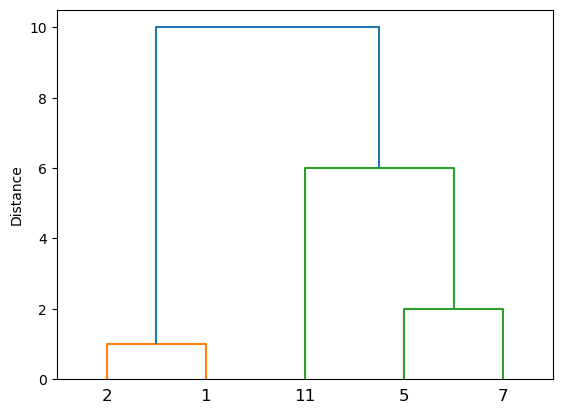

In [14]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'complete')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

最長距離法は全ての要素同士の距離が短い２つのクラスタを併合していく傾向にあるため、直径の小さいクラスタが生成されやすい。一方で、距離が近い要素同士を含む２つのクラスタがなかなか併合されない状況が生まれる。例えば、上のデンドログラムの例ではクラスタ$\{1,2\}$と$\{5,7\}$は$2$と$5$の距離が$3$で近そうに見えるが、最遠の組である$\{1,7\}$の距離$6$が考慮されるため、この2つのクラスタの併合は先延ばしにされてしまう。

### 群平均法

群平均法（group averaging method）は、最短距離法と最長距離法を織り交ぜたような手法である。２つのクラスタ$C_a$と$C_b$があるとき、そのクラスタ間距離関数は、

<a id="f11-12"></a>
(11.12)  
\begin{align}
\mathrm{dist}_{\textrm{average}}(C_a, C_b) = \frac{1}{|C_a||C_b|}\sum_{\pmb{x} \in C_a,\; \pmb{y} \in C_b} d(\pmb{x}, \pmb{y})
\end{align}

最短距離法や最長距離法では、２つのクラスタに属する１組の事例間の距離でクラスタ間の距離が定義されていたが、群平均法ではクラスタ間の事例組の全ての距離の平均を用いる（下図参照）。

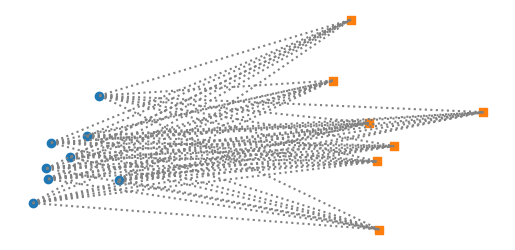

In [15]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(C0[:,0], C0[:,1], color=cmap(0), marker='o')
ax.scatter(C1[:,0], C1[:,1], color=cmap(1), marker='s')
for i in range(C0.shape[0]):
    for j in range(C1.shape[0]):
        ax.plot([C0[i][0], C1[j][0]], [C0[i][1], C1[j][1]], linestyle=':', color='gray')
ax.set_aspect('equal')
ax.axis("off")
plt.show()

群平均法のデンドログラムの例を示した。形状としては最短距離法と同じであるが、クラスタが併合されるときの距離が長くなっていることが分かる。

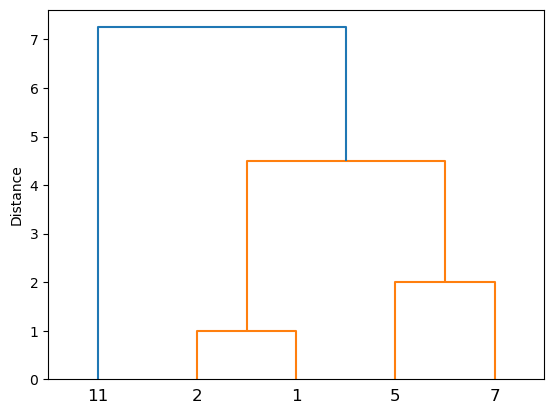

In [16]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'average')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

### 重心法

重心法は、各クラスタをそのクラスタに属する事例ベクトルの重心で代表させ、その重心間のユークリッド距離でクラスタ間の距離を定義する。２つのクラスタ$C_a$と$C_b$があるとき、クラスタ間距離は、

<a id="f11-13"></a>
(11.13)  
\begin{align}
\mathrm{dist}_{\mathrm{centroid}}(C_a, C_b) = \|\pmb{\mu}_{C_a} - \pmb{\mu}_{C_b}\|,\; \pmb{\mu}_{C_a} = \frac{1}{|C_a|}\sum_{\pmb{x} \in C_a} \pmb{x},\; \pmb{\mu}_{C_b} = \frac{1}{|C_b|}\sum_{\pmb{y} \in C_b} \pmb{y}
\end{align}


以下の図では、丸印と四角印のクラスタ間の重心をx印で示した。この重心間のユークリッド距離がクラスタ間距離として採用される。

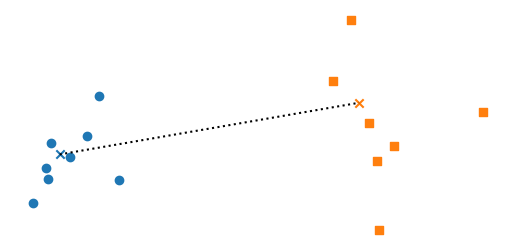

In [17]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(C0[:,0], C0[:,1], color=cmap(0), marker='o')
ax.scatter(C1[:,0], C1[:,1], color=cmap(1), marker='s')
ax.scatter(centers[:1,0], centers[:1,1], color=cmap(0), marker='x')
ax.scatter(centers[1:,0], centers[1:,1], color=cmap(1), marker='x')
ax.plot(centers[:,0], centers[:,1], linestyle=':', color='black')
ax.set_aspect('equal')
ax.axis("off")
plt.show()

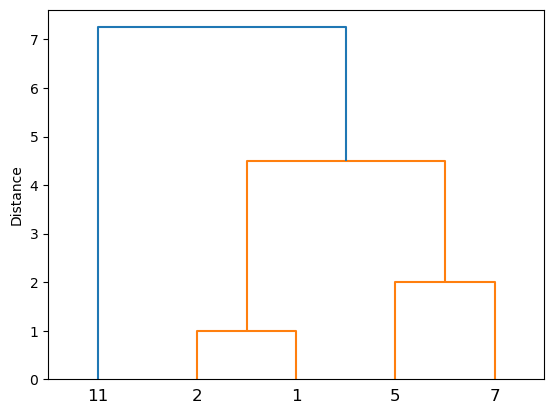

In [18]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'centroid')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

重心法のデンドログラムの例を示した。クラスタ$\{1,2\}$の重心は$1.5$、$\{5,7\}$の重心は$6$であるから、$\{1,2\}$と$\{5,7\}$の２つのクラスタは距離$6 - 1.5 = 4.5$で併合されている。

### ウォード法

**ウォード法**（Ward's method）はこれまでの凝集型クラスタリングとは異なり、クラスタ間距離ではなく、クラスタ内平方和に基づいたクラスタリング手法である。まず、あるクラスタ$C$のクラスタ内変動を定義する。

<a id="f11-14"></a>
(11.14)  
$$
\begin{align}
V(C) = \sum_{\pmb{x} \in C} \|\pmb{x} - \pmb{\mu}_C\|^2, \; \pmb{\mu}_C = \frac{1}{|C|}\sum_{\pmb{x} \in C} \pmb{x}
\end{align}
$$

いま、データが$K$個のクラスタ$C_1, C_2, \dots, C_K$に分けられているとき、全てのクラスタのクラスタ内変動の和、すなわちクラスタ内平方和は、

<a id="f11-15"></a>
(11.15)  
\begin{align}
V(C_1) + V(C_2) + \dots + V(C_K) = \sum_{k=1}^K V(C_k) = \sum_{k=1}^K \sum_{\pmb{x} \in C_k} \|\pmb{x} - \pmb{\mu}_{C_k}\|^2
\end{align}

このクラスタ内平方和はK-meansの目的関数と同じであるが、ウォード法は凝集型クラスタリングの手順でクラスタ内平方和の最小化を目指す。

凝集型クラスタリングでは、各事例がそれぞれ１つのクラスタを構成する状態が出発点であり、その時のクラスタ内平方和は$0$である。その後、クラスタを併合していくにつれて、クラスタ内平方和が上昇していく。そこで、クラスタ内平方和の上昇が少ない２つのクラスタを選び、併合していく。ある２つのクラスタ$C_a$と$C_b$を併合してクラスタ$C_a \cup C_b$を作ったとき、クラスタ内平方和の上昇分$\Delta (C_a, C_b)$は、次式で計算できる（この式の証明は後回しにする）。

<a id="f11-16"></a>
(11.16)  
$$
\begin{align}
\Delta (C_a, C_b) &= V(C_a \cup C_b) - V(C_a) - V(C_b) \\
&= \frac{|C_a||C_b|}{|C_a| + |C_b|} \|\pmb{\mu}_{C_a} - \pmb{\mu}_{C_b}\|^2
\end{align}
$$


---

#### 【補足】2倍して平方根を取る理由

全クラスタがそれぞれ要素を１つ保有する状態（クラスタリングの開始時点）を考える。2つのクラスタ$C_i = \{\pmb{x}_i\},\; C_j = \{\pmb{x}_j\}$を併合するとき、クラスタ内平方和の上昇分より、

\begin{align*}
\Delta (C_i, C_j) &= \frac{1 \cdot 1}{1 + 1} \|\pmb{x}_i - \pmb{y}_j\|^2 \\
\|\pmb{x}_i - \pmb{y}_j\| &= \sqrt{2 \Delta (C_i, C_j)}
\end{align*}


---

ウォード法は、クラスタ内平方和の上昇が最も低い２つのクラスタを併合する、という操作を$N-1$回繰り返す。これにより、クラスタ内変動の小さいコンパクトなクラスタを形成することを目指す。式[(11.16)](#f11-16)を用いてクラスタを求めてもよいが、クラスタ間の距離をユークリッド距離に相当させる場合、クラスタ間距離として次式が用いられる。

<a id="f11-17"></a>
(11.17)  
$$
\begin{align}
\mathrm{dist}_{\mathrm{ward}}(C_a, C_b) = \sqrt{2 \Delta (C_a, C_b)} = \sqrt{\frac{2|C_a||C_b|}{|C_a| + |C_b|}}\|\pmb{\mu}_{C_a} - \pmb{\mu}_{C_b}\|
\end{align}
$$

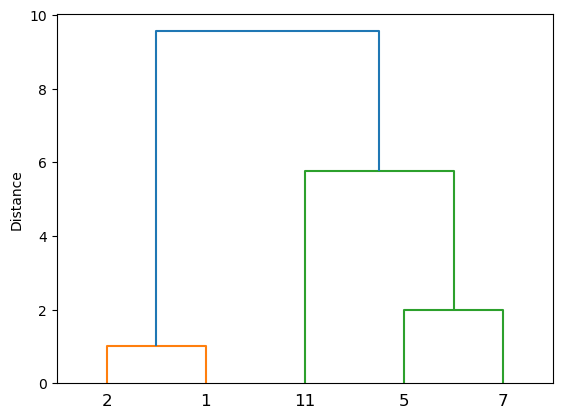

In [19]:
Z = scipy.cluster.hierarchy.linkage(X[:,None], 'ward')

fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X), ax=ax)
ax.set_ylabel("Distance")
plt.show()

ウォード法のデンドログラムを示した。このデンドログラムの縦軸はクラスタを併合したときのクラスタ間距離（式[(11.17)](#f11-17)）である。ウォード法のクラスタリングの冒頭では、ユークリッド距離が最も近い要素が併合される。この例の場合は、ユークリッド距離が最も近い要素は$\{2\}$と$\{1\}$で、そのユークリッド距離は$1$である。式[(11.17)](#f11-17)よりクラスタ間距離は$1$、式[(11.16)](#f11-16)よりクラスタ内平方和の上昇分は$\frac{1}{2}$である。続いて、$\{5\}$と$\{7\}$が併合され、式[(11.17)](#f11-17)よりクラスタ間距離は$2$、式[(11.16)](#f11-16)よりクラスタ内平方和の上昇分は$2$である。次に、$\{11\}$と$\{5,7\}$が併合されるが、その時のクラスタ間距離は$5.77$である。最後に、$\{2,1\}$と$\{11,5,7\}$が併合されるときのクラスタ間距離は$9.55$である。

さて、式[(11.16)](#f11-16)を証明する。表記を簡潔にするため、統合されるクラスタ$C_a, C_b$をそれぞれ、$A, B$と書くことにする。$A \cap B = \emptyset$であることに注意し、クラスタ内変動の定義（式[(11.14)](#f11-14)）を用いると、クラスタ内平方和の上昇分$\Delta (A, B)$（式[(11.16)](#f11-16)の冒頭の等式）は次のように展開できる。

<a id="f11-18"></a>
(11.18)  
$$
\begin{align}
\Delta (A, B) &= V(A \cup B) - V(A) - V(B) \\
&= \sum_{\pmb{x} \in {A \cup B}} \|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \sum_{\pmb{x} \in A} \|\pmb{x} - \pmb{\mu}_A\|^2 - \sum_{\pmb{x} \in B} \|\pmb{x} - \pmb{\mu}_B\|^2 \\
&= \sum_{\pmb{x} \in A} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_A\|^2\right) + \sum_{\pmb{x} \in B} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_B\|^2\right)
\end{align}
$$

ここで、式[(11.18)](#f11-18)の第1項は、

<a id="f11-19"></a>
(11.19)  
\begin{align}
& \sum_{\pmb{x} \in A} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_A\|^2\right) \\
=& \sum_{\pmb{x} \in A} \left\{ \|\pmb{x}\|^2 -2\pmb{x}\cdot\pmb{\mu}_{A \cup B} + \|\pmb{\mu}_{A \cup B}\|^2 - \left(\|\pmb{x}\|^2 - 2\pmb{x}\cdot\pmb{\mu}_A + \|\pmb{\mu}_A\|^2\right) \right\} \\
=& \sum_{\pmb{x} \in A} \left(-2\pmb{x}\cdot\pmb{\mu}_{A \cup B} + \|\pmb{\mu}_{A \cup B}\|^2 + 2\pmb{x}\cdot\pmb{\mu}_A - \|\pmb{\mu}_A\|^2 \right) \\
=& -2(|A|\pmb{\mu}_A)\cdot\pmb{\mu}_{A \cup B} + |A|\cdot\|\pmb{\mu}_{A \cup B}\|^2 + 2(|A|\pmb{\mu}_A)\cdot\pmb{\mu}_A - |A|\cdot\|\pmb{\mu}_A\|^2 \\
=& -2(|A|\pmb{\mu}_A)\cdot\pmb{\mu}_{A \cup B} + |A|\cdot\|\pmb{\mu}_{A \cup B}\|^2 + |A|\cdot\|\pmb{\mu}_A\|^2 \\
=& |A|\cdot \|\pmb{\mu}_A - \pmb{\mu}_{A \cup B}\|^2
\end{align}

同様に、式[(11.18)](#f11-18)の第2項は、

<a id="f11-20"></a>
(11.20)  
\begin{align}
\sum_{\pmb{x} \in B} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_B\|^2\right) = |B|\cdot \|\pmb{\mu}_B - \pmb{\mu}_{A \cup B}\|^2
\end{align}

ところで、クラスタ$A \cup B$の中心$\pmb{\mu}_{A \cup B}$は、$(|A|\pmb{\mu}_{A} + |B|\pmb{\mu}_{B})$を$|A| + |B|$で割ったものであるから、

<a id="f11-21"></a>
(11.21)  
\begin{align}
\pmb{\mu}_{A \cup B} &= \frac{|A|\pmb{\mu}_{A} + |B|\pmb{\mu}_{B}}{|A| + |B|} \\
&= \pmb{\mu}_{A} - \frac{|A| + |B|}{|A| + |B|}\pmb{\mu}_{A} + \frac{|A|\pmb{\mu}_{A} + |B|\pmb{\mu}_{B}}{|A| + |B|} = \pmb{\mu}_{A} - \frac{|B|}{|A| + |B|}(\pmb{\mu}_{B} - \pmb{\mu}_{A}) \\
&= \pmb{\mu}_{B} - \frac{|A| + |B|}{|A| + |B|}\pmb{\mu}_{B} + \frac{|A|\pmb{\mu}_{A} + |B|\pmb{\mu}_{B}}{|A| + |B|} = \pmb{\mu}_{B} - \frac{|A|}{|A| + |B|}(\pmb{\mu}_{A} - \pmb{\mu}_{B})
\end{align}

ゆえに、式[(11.18)](#f11-18)は、

<a id="f11-22"></a>
(11.22)  
\begin{align}
\Delta (A, B) &= V(A \cup B) - V(A) - V(B) \\
&= \sum_{\pmb{x} \in A} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_A\|^2\right) + \sum_{\pmb{x} \in B} \left(\|\pmb{x} - \pmb{\mu}_{A \cup B}\|^2 - \|\pmb{x} - \pmb{\mu}_B\|^2\right) \\
&= |A|\cdot \|\pmb{\mu}_A - \pmb{\mu}_{A \cup B}\|^2 + |B|\cdot \|\pmb{\mu}_B - \pmb{\mu}_{A \cup B}\|^2 \\
&= |A|\cdot \left\|\frac{|B|}{|A| + |B|}(\pmb{\mu}_{B} - \pmb{\mu}_{A})\right\|^2 + |B|\cdot\left\|\frac{|A|}{|A| + |B|}(\pmb{\mu}_{A} - \pmb{\mu}_{B})\right\|^2 \\
&= |A|\cdot \frac{|B|^2}{(|A| + |B|)^2}\|\pmb{\mu}_{B} - \pmb{\mu}_{A}\|^2 + |B|\cdot\frac{|A|^2}{(|A| + |B|)^2}\|\pmb{\mu}_{A} - \pmb{\mu}_{B}\|^2 \\
&= \left(\frac{|A||B|^2}{(|A| + |B|)^2} + \frac{|A|^2|B|}{(|A| + |B|)^2}\right) \|\pmb{\mu}_{A} - \pmb{\mu}_{B}\|^2 \\
&= \frac{|A||B|(|A| + |B|)}{(|A| + |B|)^2}\|\pmb{\mu}_{A} - \pmb{\mu}_{B}\|^2 \\
&= \frac{|A||B|}{|A| + |B|}\|\pmb{\mu}_{A} - \pmb{\mu}_{B}\|^2
\end{align}

（証明終）

## SciPyでの実装例

冒頭のデータ $X = (2, 11, 5, 1, 7)$ を例に、最短距離法の実装を紹介する。

In [20]:
X_ = np.array([2, 11, 5, 1, 7])

事例数を$N$、各事例の特徴ベクトルの次元数を$m$とすると、クラスタリングのデータは$N \times m$の行列で表現することが多いので、以下のプログラムで形式を変換する。

In [21]:
X = X_[:,None]
X

array([[ 2],
       [11],
       [ 5],
       [ 1],
       [ 7]])

### 距離行列を求める

データから距離行列を得るには、[scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)を使えばよい。以下のコードは都市ブロック距離（cityblock distance）、つまりマンハッタン距離を求めるものである。

In [22]:
D = scipy.spatial.distance.pdist(X, 'cityblock')
D

array([ 9.,  3.,  1.,  5.,  6., 10.,  4.,  4.,  2.,  6.])

この実行結果は、距離行列の非対角成分を並べたものである（condensed形式）。正方な距離行列に変換するには、[scipy.spatial.distance.squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)を用いればよい。

In [23]:
scipy.spatial.distance.squareform(D)

array([[ 0.,  9.,  3.,  1.,  5.],
       [ 9.,  0.,  6., 10.,  4.],
       [ 3.,  6.,  0.,  4.,  2.],
       [ 1., 10.,  4.,  0.,  6.],
       [ 5.,  4.,  2.,  6.,  0.]])

### クラスタリングの実行
condensed形式の距離行列を引数として[scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)を呼び出すと、階層的クラスタリングが実行される。以下では`method='single'`とすることで、最短距離法を指定している。

In [24]:
Z = scipy.cluster.hierarchy.linkage(D, 'single')
Z

array([[0., 3., 1., 2.],
       [2., 4., 2., 2.],
       [5., 6., 3., 4.],
       [1., 7., 4., 5.]])

この実行結果を理解するには、[scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)のドキュメントを読む必要がある。該当する部分を日本語に訳したものを示す。

> $(n-1) \times 4$の行列`Z`が返される。$i$番目の反復において、`Z[i,0]`と`Z[i,1]`で表されるインデックスのクラスタが併合され、インデックスが$n+i$のクラスタが形成される。$n$よりも小さいインデックス番号のクラスタは$n$件の事例を表す。クラスタ`Z[i,0]`と`Z[i,1]`の距離は`Z[i,2]`で与えられる。4列目の要素`Z[i,3]`はこのクラスタに属する事例の数である。

したがって、`Z`は以下のようにクラスタが形成されたことを表している。

+ $5$番のクラスタ: 距離$1$で離れている$0$番と$3$番のクラスタを併合した（併合されたクラスタの要素数は$2$）
+ $6$番のクラスタ: 距離$2$で離れている$2$番と$4$番のクラスタを併合した（併合されたクラスタの要素数は$2$）
+ $7$番のクラスタ: 距離$3$で離れている$5$番と$6$番のクラスタを併合した（併合されたクラスタの要素数は$4$）
+ $8$番のクラスタ: 距離$4$で離れている$1$番と$7$番のクラスタを併合した（併合されたクラスタの要素数は$5$）

クラスタリングの実行結果を表す`Z`からデンドログラムを描くには、[scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)を呼び出せばよい。

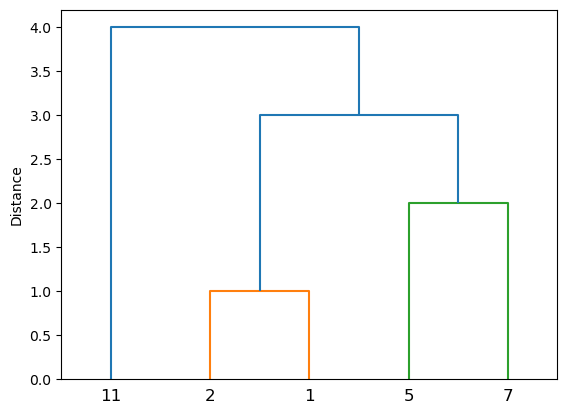

In [25]:
fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X_), ax=ax)
ax.set_ylabel("Distance")
plt.show()

クラスタリングの実行結果を表す`Z`を用いて、指定した距離の閾値でクラスタを取り出すには、[scipy.cluster.hierarchy.fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html)を用いればよい。なお、実行結果の理解を助けるため、元のデータ`X_`を再掲する。

In [26]:
X_

array([ 2, 11,  5,  1,  7])

In [27]:
scipy.cluster.hierarchy.fcluster(Z, t=1.5, criterion='distance')

array([1, 4, 2, 1, 3], dtype=int32)

In [28]:
scipy.cluster.hierarchy.fcluster(Z, t=2.5, criterion='distance')

array([1, 3, 2, 1, 2], dtype=int32)

In [29]:
scipy.cluster.hierarchy.fcluster(Z, t=3.5, criterion='distance')

array([1, 2, 1, 1, 1], dtype=int32)

In [30]:
scipy.cluster.hierarchy.fcluster(Z, t=4.5, criterion='distance')

array([1, 1, 1, 1, 1], dtype=int32)

また、`criterion`に`'maxclust'`を指定することで、指定した数のクラスタが得られる（距離の閾値が自動的に調整される）。

In [31]:
scipy.cluster.hierarchy.fcluster(Z, t=3, criterion='maxclust')

array([1, 3, 2, 1, 2], dtype=int32)

なお、標準的な距離関数を用いるのであれば、距離行列を介せずに`X`から直接クラスタリングを実行できる。以下の例は最長距離法（`method='complete'`）を実行する例である。

In [32]:
Z = scipy.cluster.hierarchy.linkage(X, 'complete', metric='cityblock')
Z

array([[ 0.,  3.,  1.,  2.],
       [ 2.,  4.,  2.,  2.],
       [ 1.,  6.,  6.,  3.],
       [ 5.,  7., 10.,  5.]])

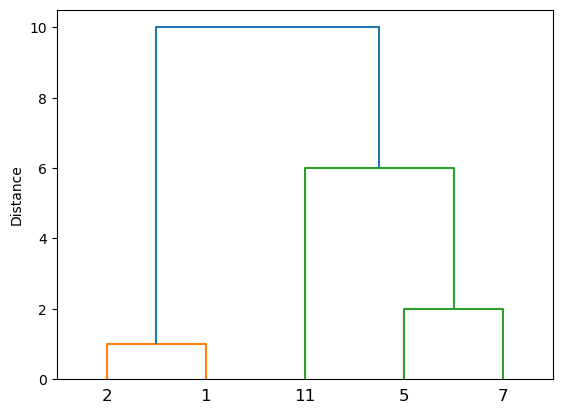

In [33]:
fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X_), ax=ax)
ax.set_ylabel("Distance")
plt.show()

## 自前で実装

クラスタリングを行うデータを再掲する（$N \times 1$の行列形式である）。

In [34]:
X_ = np.array([2, 11, 5, 1, 7])
X = X_[:,None]
X

array([[ 2],
       [11],
       [ 5],
       [ 1],
       [ 7]])

$L_1$距離でデータから距離行列を作成するプログラムは、安直に実装すると次のようになる。

In [35]:
def distance_matrix_L1(X):
    D = np.zeros((X.shape[0], X.shape[0]), dtype=np.float)
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            D[i,j] = np.abs(X[i] - X[j]).sum()
    return D

In [36]:
distance_matrix_L1(X)

/tmp/ipykernel_83/2120723779.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  D = np.zeros((X.shape[0], X.shape[0]), dtype=np.float)


array([[ 0.,  9.,  3.,  1.,  5.],
       [ 9.,  0.,  6., 10.,  4.],
       [ 3.,  6.,  0.,  4.,  2.],
       [ 1., 10.,  4.,  0.,  6.],
       [ 5.,  4.,  2.,  6.,  0.]])

これは、以下のように書くこともできる。

In [37]:
def distance_matrix_L1(X):
    return np.abs(X[:, None] - X).sum(axis=2).astype(np.float)

In [38]:
distance_matrix_L1(X)

/tmp/ipykernel_83/3303083371.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.abs(X[:, None] - X).sum(axis=2).astype(np.float)


array([[ 0.,  9.,  3.,  1.,  5.],
       [ 9.,  0.,  6., 10.,  4.],
       [ 3.,  6.,  0.,  4.,  2.],
       [ 1., 10.,  4.,  0.,  6.],
       [ 5.,  4.,  2.,  6.,  0.]])

なお、この実装方法は以下のコードの実行結果がヒントになるが、それでも分かりづらいかもしれない。

In [39]:
X[:, None] - X

array([[[  0],
        [ -9],
        [ -3],
        [  1],
        [ -5]],

       [[  9],
        [  0],
        [  6],
        [ 10],
        [  4]],

       [[  3],
        [ -6],
        [  0],
        [  4],
        [ -2]],

       [[ -1],
        [-10],
        [ -4],
        [  0],
        [ -6]],

       [[  5],
        [ -4],
        [  2],
        [  6],
        [  0]]])

先ほど説明した[scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)に準拠した出力になるように、最短距離法を実装する。主な変数の意味は以下のとおりである。

+ `M`: $(2N-1)\times(2N-1)$の距離行列（対称行列）。$0$から$N-1$までの行や列は各事例それぞれのクラスタを表し、$N$から$2N-2$までの行や列は併合されて作成されたクラスタを表す
+ `C`: $2N-1$のベクトル。`C[k]`はクラスタ$k$の要素数を表す
+ `Z`: [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)に準拠したクラスタリング結果を格納する行列

なお、クラスタを併合するときに距離行列の行や列を削除すると実装がややこしくなるので、削除されたとみなされる要素に`np.inf`を代入して、仮想的に行や列が削除された状態を作り出しているのがポイントである。

In [40]:
def single_linkage(D):
    C = np.ones(len(D) * 2 - 1)
    Z = np.zeros((len(D)-1, 4), dtype=np.float)
    M = np.pad(D, (0, len(D)-1), constant_values=np.inf)
    np.fill_diagonal(M, np.inf)
    
    print("* t=0")
    print(M)
    
    for t in range(len(D), len(D)*2 - 1):
        # Find the pair of the closest clusters (i,j) to be merged.
        S = M[:t,:t]
        i, j = np.unravel_index(np.argmin(S), S.shape)
        print('argmin =', (i, j))
        
        # Record the number of elements in the new cluster.
        C[t] = C[i] + C[j]
        
        # Record the new cluster in the linkage matrix.
        Z[t-len(D)] = (i, j, S[i,j], C[t])
        
        # Remove the distance between i and j.
        M[((i,j), (j,i))] = np.inf
        
        # Compute distance from the new cluster to the others.
        M[t] = np.minimum(M[i], M[j])
        M[:,t] = np.minimum(M[:,i], M[:,j])

        # Remove the distance for the clusters i and j.
        M[i] = np.inf
        M[j] = np.inf
        M[:,i] = np.inf
        M[:,j] = np.inf
        
        print(f"* t={t}")
        print(M)
    return Z

In [41]:
D = distance_matrix_L1(X)
Z = single_linkage(D)

* t=0
[[inf  9.  3.  1.  5. inf inf inf inf]
 [ 9. inf  6. 10.  4. inf inf inf inf]
 [ 3.  6. inf  4.  2. inf inf inf inf]
 [ 1. 10.  4. inf  6. inf inf inf inf]
 [ 5.  4.  2.  6. inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]]
argmin = (0, 3)
* t=5
[[inf inf inf inf inf inf inf inf inf]
 [inf inf  6. inf  4.  9. inf inf inf]
 [inf  6. inf inf  2.  3. inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf  4.  2. inf inf  5. inf inf inf]
 [inf  9.  3. inf  5. inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]]
argmin = (2, 4)
* t=6
[[inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf  9.  4. inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf inf inf]
 [inf  9. inf inf inf inf  3. inf inf]
 [inf  4. in

/tmp/ipykernel_83/3303083371.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.abs(X[:, None] - X).sum(axis=2).astype(np.float)
/tmp/ipykernel_83/721719877.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Z = np.zeros((len(D)-1, 4), dtype=np.float)


求めたクラスタリング結果`Z`を用いて、デンドログラムを描いてみる。

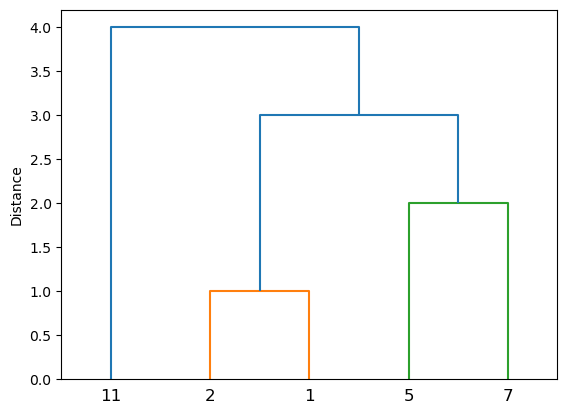

In [42]:
fig, ax = plt.subplots(dpi=100)
dn = scipy.cluster.hierarchy.dendrogram(Z, labels=list(X_), ax=ax)
ax.set_ylabel("Distance")
plt.show()

## 確認問題

[教育用標準データセット（SSDSE）](https://www.nstac.go.jp/SSDSE/)に収録されている都道府県庁所在市別・家計消費データ（SSDSE-C）に対してクラスタ分析を適用し、消費行動が類似している都道府県のクラスタを作りたい。最短距離法、最長距離法、Ward法を用いて都道府県をクラスタリングし、デンドログラムをそれぞれ描画せよ。ただし、クラスタの各要素がどの都道府県であるか分かるようにせよ。

In [43]:
from pathlib import Path
import pandas as pd

csv_path = Path("./data/ssdse-c-2022.csv")
raw_df = pd.read_csv(csv_path)

余分な行を削除する。

In [44]:
code_name = raw_df.iloc[0,:]  # コードの名称記載行を取得
df = raw_df.drop(0, axis=0) # 不要な行の削除
location_name = df.iloc[:,:3]  # 県庁所在地名を取得
location_name.set_index("SSDSE-C-2022", inplace=True)
df = df.drop(["Prefecture", "City"], axis=1) # 不要な列の削除
df = df.set_index("SSDSE-C-2022")  # 県庁所在地のコードをindexにする
df = df.astype("float32")  # 数値型に変換

In [45]:
df.head(5)

,LA03,LB00,LB01,LB011001,LB012001,LB012002,LB013001,LB013002,LB013003,LB013004,...,LB121104,LB121105,LB121106,LB121107,LB121108,LB121109,LB121110,LB121201,LB121202,LB122001
SSDSE-C-2022,,,,,,,,,,,,,,,,,,,,,
R00000,2.95,960240.0,79678.0,22998.0,10163.0,21494.0,3513.0,2230.0,1312.0,4367.0,...,13620.0,19716.0,4179.0,9794.0,6184.0,5067.0,44164.0,6522.0,11358.0,9713.0
R01100,2.84,942332.0,82566.0,29665.0,9367.0,18496.0,3214.0,2113.0,1280.0,4360.0,...,16906.0,22845.0,3772.0,15761.0,7132.0,4187.0,20326.0,5462.0,14817.0,13273.0
R02201,2.87,892205.0,73320.0,21932.0,8285.0,17063.0,3164.0,2258.0,1196.0,5592.0,...,12594.0,13802.0,2748.0,6796.0,5794.0,3991.0,14162.0,2833.0,6874.0,9698.0
R03201,3.12,937554.0,79379.0,23297.0,8402.0,20278.0,3435.0,2199.0,1302.0,6223.0,...,11490.0,9847.0,1826.0,5333.0,4951.0,3884.0,35759.0,4046.0,11100.0,10647.0
R04100,3.00,972504.0,75346.0,20686.0,8875.0,20314.0,3128.0,2051.0,1343.0,4985.0,...,12384.0,16022.0,2890.0,7540.0,6073.0,4585.0,35037.0,5097.0,7996.0,9177.0


クラスタリングを実施する。[11.4. SciPyでの実装例](https://chokkan.github.io/mlnote/unsupervised/02hac.html#scipy)を参考に、次の手順でクラスタリングを行う。  


1. 距離行列を求める: [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)  
2. クラスタリングを行う: [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)  
3. デンドログラムを描画する: [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)  


これらを実行する関数を作成する。

In [46]:
import scipy
import scipy.cluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def clustering(df, method, metric="euclidean"):
    _X = StandardScaler().fit_transform(df)
    distance_matrix = scipy.spatial.distance.pdist(_X, metric=metric)
    cluster = scipy.cluster.hierarchy.linkage(distance_matrix, method=method, metric=metric)

    figure, ax = plt.subplots(dpi=100)
    dn = scipy.cluster.hierarchy.dendrogram(cluster, labels=df.index, ax=ax)
    ax.set_ylabel("Distance")
    plt.show()
    return dn

### 最短距離法  

最短距離法は `method=single` で指定する。  
クラスタが連鎖して繋がっていく様子が分かる。  

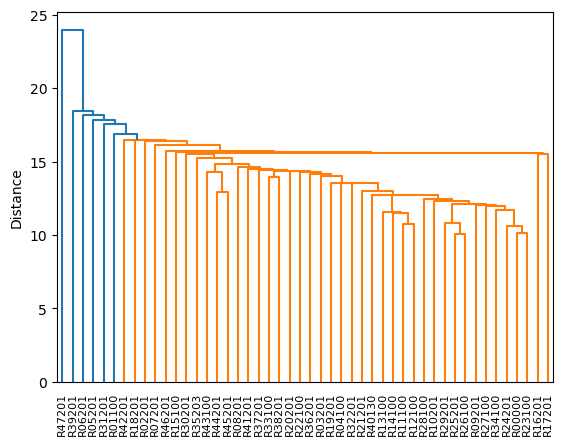

,R47201,R39201,R06201,R05201,R31201,R01100,R42201,R18201,R02201,R07201,...,R25201,R26100,R09201,R27100,R34100,R24201,R00000,R23100,R16201,R17201
0,那覇市,高知市,山形市,秋田市,鳥取市,札幌市,長崎市,福井市,青森市,福島市,...,大津市,京都市,宇都宮市,大阪市,広島市,津市,全国,名古屋市,富山市,金沢市


In [47]:
result = clustering(df, method="single")
pd.Series([location_name[location_name.index == idx].City[0] for idx in result["ivl"]], index=result["ivl"]).to_frame().T

### 最長距離法  

最長距離法は `method=complete` で指定する。  
最短距離法よりそれぞれのクラスタごとにまとまっている様子が見える。ただ、1つ1つのクラスタの大きさは小さい。  

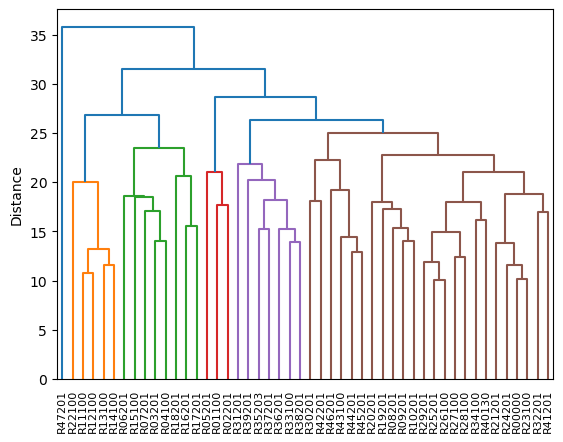

,R47201,R22100,R11100,R12100,R13100,R14100,R06201,R15100,R07201,R03201,...,R27100,R28100,R34100,R40130,R21201,R24201,R00000,R23100,R32201,R41201
0,那覇市,静岡市,さいたま市,千葉市,東京都区部,横浜市,山形市,新潟市,福島市,盛岡市,...,大阪市,神戸市,広島市,福岡市,岐阜市,津市,全国,名古屋市,松江市,佐賀市


In [48]:
result = clustering(df, method="complete")
pd.Series([location_name[location_name.index == idx].City[0] for idx in result["ivl"]], index=result["ivl"]).to_frame().T

###  Ward法  

最長距離法はmethod=wardで指定する。  
割合大きな塊が2つに分かれているのがわかる。  

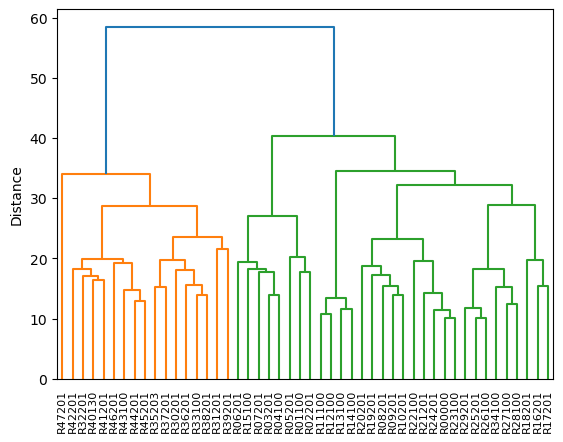

,R47201,R42201,R32201,R40130,R41201,R46201,R43100,R44201,R45201,R35203,...,R23100,R29201,R25201,R26100,R34100,R27100,R28100,R18201,R16201,R17201
0,那覇市,長崎市,松江市,福岡市,佐賀市,鹿児島市,熊本市,大分市,宮崎市,山口市,...,名古屋市,奈良市,大津市,京都市,広島市,大阪市,神戸市,福井市,富山市,金沢市


In [49]:
result = clustering(df, method="ward")
pd.Series([location_name[location_name.index == idx].City[0] for idx in result["ivl"]], index=result["ivl"]).to_frame().T

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2022 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。